# Funções para ciência dos dados:

##### As funções aqui produzidas foram feitas por alunos, para todos que desejarem utilizá-las.

In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import * ## Não julgue.
import os.path
import json
import re
import string
import functools
import operator
from random import shuffle
from numpy.polynomial.polynomial import polyfit
try:
    import emoji;
finally:
    !pip install emoji --upgrade
    import emoji;

Requirement already up-to-date: emoji in c:\programdata\anaconda3\lib\site-packages (0.5.4)


In [92]:
def prob_between(a, b, loc = 0, scale = 1, avg_occurences = 1, n = 1, p = 0.5,  kind = 'norm'):
    ## Função para calcular a probabilidade P(X=x), com b <= x <= a
    
    ## a = Um dos limites de integração, ou, um dos limites para a variável aleatória. 
    ## b = Um dos limites de integração, ou, um dos limites para a variável aleatória.
    ## loc = média; usado para distribuição normal e exponencial.
    ## scale = desvio padrão, usado para distribuição normal e exponencial.
    ## avg_occurences = Número médio de ocorrências por unidade de tempo, comumente, lambda.
    ## n = número de experimentos para as distribuições bernoulli e binomial.
    ## p = probabilidade de um evento de bernoulli ou binomial.
    ## kind = tipo de distribuição.
    
    mini, maxi = min(a,b), max(a,b)
    
    kinds = {
        'poisson': False,
        'binom': False,
        'bern': False,
        'expon': False
    }
    
    if kind in kinds:
        kinds[kind] = True
    else:
        return -1
        
    if kinds['poisson']:
        return poison.cdf(maxi, mu = avg_occurences) - poison.cdf(mini,  mu = avg_occurences)
    if kinds['binom']:
        return binom.cdf(maxi, n = n, p = p) - binom.cdf(mini,  n = n, p = p)
    if kinds['bern']:
        return 0
    if kinds['expon']:
        return expon.cdf(maxi, loc = loc, scale = scale) - expon.cdf(mini, loc = loc, scale = scale)
    return norm.cdf(maxi, loc=loc, scale=scale) - norm.cdf(mini, loc=loc, scale=scale)

def prob_greater(a, loc = 0, scale = 1, avg_occurences = 1, n = 1, p = 0.5,  kind = 'norm'):
    
    #####-------------------------------------------------#####
    ##------ IMPORTANTE: A FUNÇÃO SF DO STATS FAZ ISSO ------##
    #####-------------------------------------------------#####
    
    ## Função para calcular a probabilidade P(X=x), com x>=a.
        
    ## a = Um dos limites de integração, ou, um dos limites para a variável aleatória. 
    ## loc = média; usado para distribuição normal e exponencial.
    ## scale = desvio padrão, usado para distribuição normal e exponencial.
    ## avg_occurences = Número médio de ocorrências por unidade de tempo, comumente, lambda.
    ## n = número de experimentos para as distribuições bernoulli e binomial.
    ## p = probabilidade de um evento de bernoulli ou binomial.
    ## kind = tipo de distribuição.
    
    
    kinds = {
        'poisson': False,
        'binom': False,
        'bern': False,
        'expon': False
    }
    
    if kind in kinds:
        kinds[kind] = True
        
    if kinds['poisson']:
        return 1 - poison.cdf(a,  mu = avg_occurences)
    if kinds['binom']:
        return 1 - binom.cdf(a,  n = n, p = p)
    if kinds['bern']:
        return 1 - bern.cdf(a, p = p)
    if kinds['expon']:
        return 1 - expon.cdf(a, loc = loc, scale = scale)
    return 1 - norm.cdf(a, loc = loc, scale = scale)

def find_quantiles(percents = np.arange(0, 1.1,0.25), loc = 0, scale = 1, avg_occurences = 1, n = 1, p = 0.5,  kind = 'norm'):
    
    ## Função para calcular os quartis.
        
    ## percents = Lista (iterável), de 0 a 1, que contém os quartis que deseja-se obter.    
    ## a = Um dos limites de integração, ou, um dos limites para a variável aleatória. 
    ## loc = média; usado para distribuição normal e exponencial.
    ## scale = desvio padrão, usado para distribuição normal e exponencial.
    ## avg_occurences = Número médio de ocorrências por unidade de tempo, comumente, lambda.
    ## n = número de experimentos para as distribuições bernoulli e binomial.
    ## p = probabilidade de um evento de bernoulli ou binomial.
    ## kind = tipo de distribuição.
    
    
    kinds = {
        'poisson': False,
        'binom': False,
        'bern': False,
        'expon': False
    }
    
    if kind in kinds:
        kinds[kind] = True
        
    if kinds['poisson']:
        return [poison.ppf(i,  mu = avg_occurences) for i in percents]
    if kinds['binom']:
        return [binom.ppf(i,  n = n, p = p) for i in percents]
    if kinds['bern']:
        return [bern.ppf(i, p = p) for i in percents]
    if kinds['expon']:
        return [expon.ppf(i, loc = loc, scale = scale) for i in percents]
    
    return [norm.ppf(i, loc = loc, scale = scale) for i in percents]

def analise_dispersion(dataX, dataY, sort = True):
    y = dataY
    x = dataX 
    if sort:
        # Se quiser que ordene seus dados, para melhorar visualização, deixe True.
        y = sorted(dataY)
    b, m = polyfit(x, y, 1)
    f, ax1 = plt.subplots(figsize=(13, 10))     
    ax1.plot(x, b + m * x, '-', lw = 2.5, color="green", label = 'Tendência')
    ax1.scatter(x, y)
    ax1.legend()
    corr = pd.Series(dataX).corr(pd.Series(dataY))
    return ax1, corr #Plot, correlação de Pearson, respectivamente.

def cleanup(text):
    import string
    punctuation = '[!-.:?;]' 
    pattern = re.compile(punctuation)
    #text = ' '.join(word for word in text.split() if not word.startswith('ESCREVA OQ VC QUER TIRAR')) 
    text_subbed = re.sub(pattern, ' ', text)
    return text_subbed  

def evaluate_relevance(treino1 = pd.Series([{'FAKEWORD':5}]), treino2 = pd.Series([{'FAKEWORD':5}]), text = "", alpha = 1, V = 100000):
    
    ## -Limpando os textos
    text = cleanup(text)
    
    ## -- Calculando a probabilidade
    sumR = 0
    sumNR = 0
    T_1 = (len(treino1)+alpha*V)
    T_2 = (len(treino2)+alpha*V)
    
    for word in text.split():
        
        if word in treino1: 
            sumR += np.log((treino1[word]+alpha)/T_1)
        else:
            sumR += np.log(alpha/T_1)
        if word in treino2: 
            sumNR += np.log((T_2[word]+alpha)/T_2)
        else:
            sumNR += np.log(alpha/T_2)
    
    return sumR>sumNR

def seleciona_coluna_qualitativa(data, coluna, tipo):
    dados_selecionados = data[data[coluna] == tipo]
    return dados_selecionados

def fit_data(data, kind = 'norm'):
    f, ax1 = plt.subplots(figsize=(13, 10), dpi = 60)
    x = np.linspace(min(data), max(data), 500)
    data = pd.Series(data)
    if kind == 'expon':
        loc, scale = expon.fit(data)
        ax1.plot(x, expon.pdf(x, loc = loc, scale = scale))
        ax1.hist(data, density = True)
        return ax1, loc, scale
    else:
        loc, scale = norm.fit(data)
        ax1.plot(x, norm.pdf(x, loc = loc, scale = scale))
        ax1.hist(data, density = True)
        return ax1, loc, scale
    return -1,-1,[]


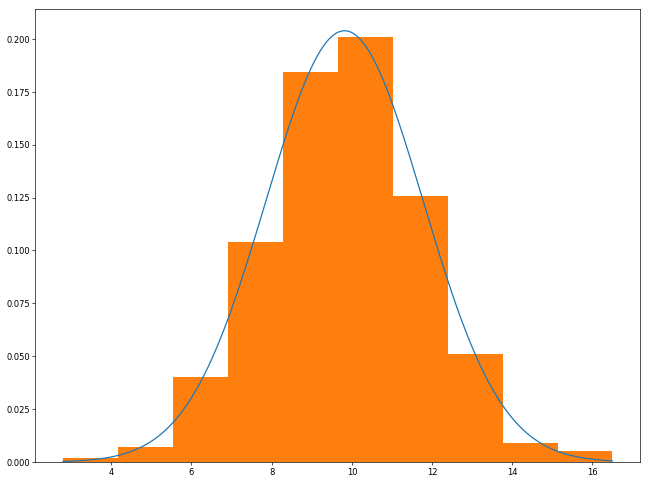

In [95]:
data = norm.rvs(loc = 10, scale = 2, size = 400)
fit_data(data, kind = 'norm');